In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B1: Marginalization

> predict + ersatz (substitute) + predict

A common way to discover what sequence features a machine learning model has learned is to consider each potential motif (from a pre-defined set), substitute it into background sequences, and look at the result averaged over all backgrounds. This is called <i>in silico marginalization</i>, with the name coming from the idea that you are "marginalizing" the effect of background sequence and looking at the <i>marginal</i> effect on model predictions from that single motif without any interactions. More concretely, if you have a set of known protein binding sites -- perhaps from a resource like JASPAR -- you can use marginalizations to see the individual effect of each protein binding site on model predictions and determine what binding sites are relevant for predictions.

Marginalizations can be done in `tangermeme` using the `marginalize` function which build on the `predict` function. Given a machine learning model, background sequences, and a motif to substitute in, `marginalize` will make predictions using the model on the background sequences, substitute the motif into the sequences, and then make predictions on these new sequences, and return both sets of predictions. If the model makes multiple sets of predictions, these are handled just as they would be from the `predict` function. 

Importantly -- it is up to the user to determine the appropriate way to take the predictions from before and after substituting in the motif and combine them into a distance representative of the effect of the perturbation. A common way is to simply take the difference in predictions, or the Euclidean distance between predictions, but the correct way will likely involve knowing the properties of the outputs of the model (e.g., is it in log scale, is it a vector of probabilities or a vector of counts, etc...).

#### Marginalize

Accordingly, the workhorse of these analyses is the `marginalize` function. This function takes in a machine learning model, one-hot encoded background sequences, and a subsequence/motif to insert into the background sequences. As described above, this function will first make predictions on the background sequences, then insert (or more accurately, `substitute`) the motif into the backgrounds, and then make predictions on the new sequences, and return all outputs in both settings to the user.

For our demonstration, let's use the Beluga model, which is an improvement over the original DeepSEA model.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

We can start off by generating some uniformly random background sequence which we will insert the motif of interest into. As a note, uniformly random characers MAY NOT BE THE BEST BACKGROUND FOR YOUR SETTING. You may want to generate sequence with the same character probabilities as those seen in native sequences, or in the genomics setting have sequences with the same GC dinucleotide percentage as some set of sequences. Here, we use uniformly random characters just to demonstrate how to use the functions.

In [3]:
from tangermeme.utils import random_one_hot

X = random_one_hot((100, 4, 2000)).type(torch.float32)  # Generate 100 random sequences to marginalize over

Now, if we have a motif that we want to insert, we can put in the characters and the alphabet (default is the nucleotide alphabet) or we can pass in a one-hot encoding. Here, let's put in an extended AP-1 motif. By default, this function will one-hot encode the characters according to the provided alphabet and then substitute those in to each of the provided sequences.

In [4]:
from tangermeme.marginalize import marginalize

y_before, y_after = marginalize(model, X, "CTCAGTGATG", device='cpu')
y_before.shape, y_after.shape

(torch.Size([100, 2002]), torch.Size([100, 2002]))

We get the predictions before and after the substitution as the output of the `marginalize` function. In this case, there were 100 background sequences used, and the Beluga model makes predictions for 2002 tasks.

For each one of Beluga's output tasks we can plot the difference in the predicted logit before and after inserting the motif across each of the 100 background sequences. Let's initially focus on those tasks with the highest difference in predictions.

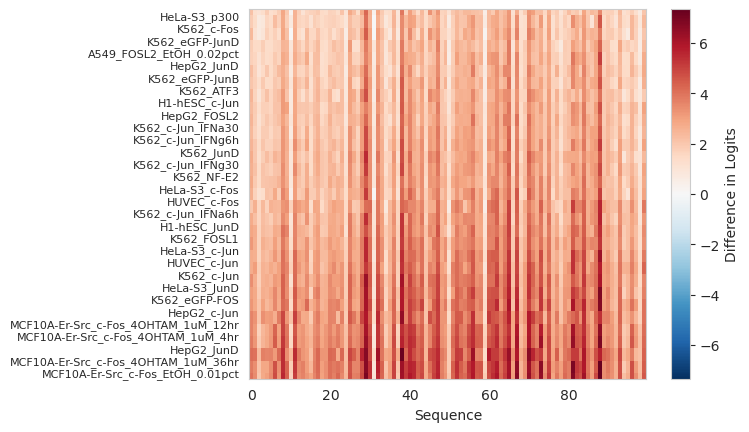

In [5]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy

names = numpy.array([name[:40].replace("_None", "") for name in numpy.loadtxt("beluga_target_names.txt", delimiter=',', dtype=str)])

y_delta = y_after - y_before
idxs = torch.flip(torch.argsort(y_delta.mean(axis=0)), dims=(0,))
ymax = max(abs(y_delta.min()), abs(y_delta.max()))


plt.imshow(y_delta[:, idxs].T, aspect='auto', cmap='RdBu_r', vmin=-ymax, vmax=ymax, interpolation='nearest')
plt.colorbar(label="Difference in Logits")
plt.ylim(0, 30)
plt.yticks(numpy.arange(0.5, 30.5, 1), names[idxs[:30]], fontsize=8)
plt.xlabel("Sequence")
plt.grid(False)
plt.show()

Looks like inserting this motif has had the largest effect on FOS/c-FOS and JUN/c-JUN tasks, greatly increasing the predicted logits in most/each of the background sequences. This makes sense because those are in the AP-1 family of proteins and all bind to the provided motif. 

Now, we can look at those tasks where the predictions were reduced the most.

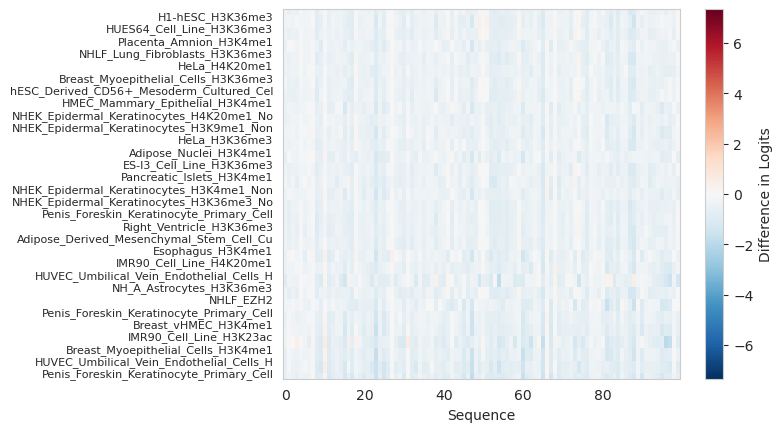

In [6]:
y_delta = y_after - y_before
idxs = torch.argsort(y_delta.mean(axis=0))
ymax = max(abs(y_delta.min()), abs(y_delta.max()))


plt.imshow(y_delta[:, idxs].T, aspect='auto', cmap='RdBu_r', vmin=-ymax, vmax=ymax, interpolation='nearest')
plt.colorbar(label="Difference in Logits")
plt.ylim(0, 30)
plt.yticks(numpy.arange(0.5, 30.5, 1), names[idxs[:30]], fontsize=8)
plt.xlabel("Sequence")
plt.grid(False)
plt.show()

Even though we are looking at tasks where the prediction decreased the most, the actual difference in predictions ended up being quite small This also makes sense because if you start off with a randomly generated region, where nothing is likely happening, and add a motif irrelevant for those tasks, it's not like the prediction should get much more negative. More concretely, inserting an AP-1 binding site is unlikely to significantly decrease your prediction of histone modifications.

We can also be a bit more comprehensive and just plot the predictions before and after insertion of the motif, averaged across all the background sequences.

Text(0, 0.5, 'Logit After Insertion')

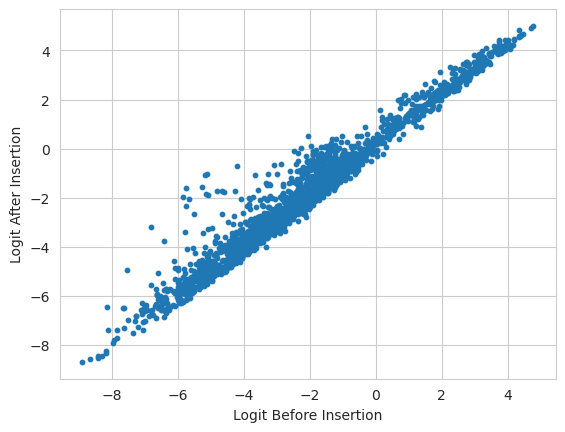

In [7]:
plt.scatter(y_before.mean(axis=0), y_after.mean(axis=0), s=10)
plt.xlabel("Logit Before Insertion")
plt.ylabel("Logit After Insertion")

Looks like a few tasks were significantly effected by the insertion of the motif whereas others were not effected at all. Remember that it is the difference we are interested in when doing in silico marginalizations, not necessarily the raw value which can be affected by a large number of other factors.

Potentially, a more visually compelling example of an in silico marginalization comes from making predictions at basepair resolution using a model like BPNet. Here, we will consider a BPNet model trained to predict GATA2 binding.

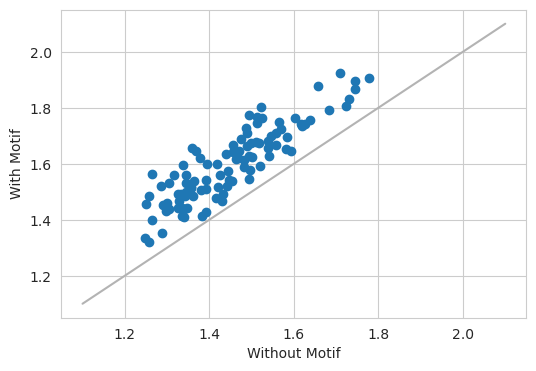

In [8]:
bpnet = torch.load("gata2.bpnet.torch")

X = random_one_hot((100, 4, 2114)).type(torch.float32)  # Generate 100 random sequences with the right size for BPNet to marginalize over
y_before, y_after = marginalize(bpnet, X, "CTTATCT", args=(torch.zeros(100, 2, 2114),), device='cpu')

plt.figure(figsize=(6, 4))
plt.scatter(y_before[1], y_after[1])
plt.plot([1.1, 2.1], [1.1, 2.1], color='0.7')
plt.xlabel("Without Motif")
plt.ylabel("With Motif")
plt.show()

Looking at the count head gives the results that one would expect -- when inserting a GATA motif into a sequence, the model predicts a larger number reads.

Next, we can look at the basepair resolution profile before and after insertion.

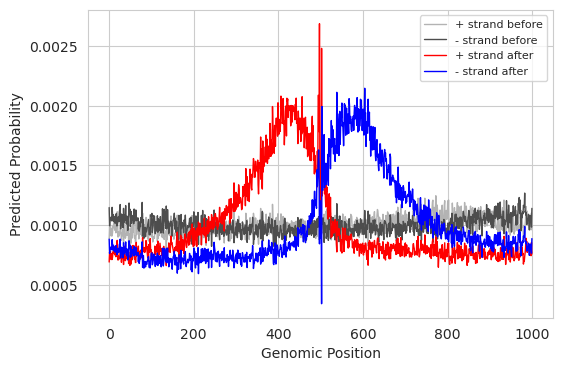

In [9]:
yb = torch.nn.functional.softmax(y_before[0].mean(axis=0), dim=-1)
ya = torch.nn.functional.softmax(y_after[0].mean(axis=0), dim=-1)

plt.figure(figsize=(6, 4))
plt.plot(yb[0], color='0.7', linewidth=1, label="+ strand before")
plt.plot(yb[1], color='0.3', linewidth=1, label="- strand before")

plt.plot(ya[0], color='r', linewidth=1, label="+ strand after")
plt.plot(ya[1], color='b', linewidth=1, label="- strand after")
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")
plt.legend(fontsize=8)
plt.show()

Here, we see that before the insertion (the two gray lines) the profile is fairly flat because there is no GATA binding site. However, after insertion, there are two peaks (one for reads mapping on the positive strand, one for reads mapping on the negative strand) centered on the motif. Plots like this show that the BPNet model is responding to the insertion of the motif, and hence that the motif is globally important.

Important, note how the function easily handled a model whose output is a simple tensor, like the Beluga model, as well as a model whose output is several tensors. When using the functions implemented in `tangermeme`, you don't have to think about these complexities.

##### Starting Position

By default, when performing marginalizations the substitution happens in the exact middle of the sequence, with an equal number of positions in the motif to the left and to the right of the middle point in the background sequences (assuming both the motif and background are an even length). If you would like to set the start position of the substitution to somewhere else you can pass in the `start` parameter. Doing so can be useful when comparing motifs of differing lengths and want to keep the set of characters that are modified as similar as possible.

As an example of the effect this can have, let's substitute the GATA motif in at position 750 instead of position 1057. This should move the output profile over by ~250 bp as well.

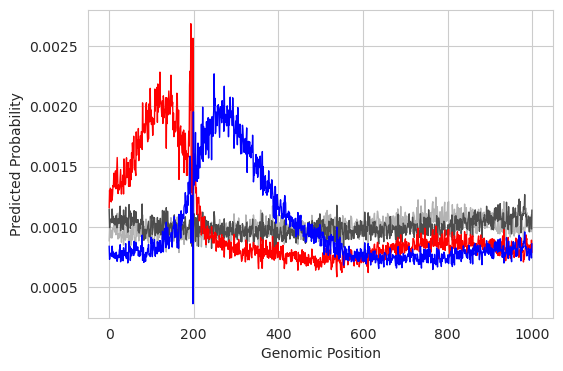

In [10]:
y_before, y_after = marginalize(bpnet, X, "CTTATCT", args=(torch.zeros(100, 2, 2114),), start=750, device='cpu')

plt.figure(figsize=(6, 4))
plt.plot(torch.nn.functional.softmax(y_before[0].mean(axis=0)[0], dim=0), color='0.7', linewidth=1)
plt.plot(torch.nn.functional.softmax(y_before[0].mean(axis=0)[1], dim=0), color='0.3', linewidth=1)

plt.plot(torch.nn.functional.softmax(y_after[0].mean(axis=0)[0], dim=0), color='r', linewidth=1)
plt.plot(torch.nn.functional.softmax(y_after[0].mean(axis=0)[1], dim=0), color='b', linewidth=1)
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Probability")
plt.show()

We can see that the output is exactly what we expected. When the position of the substituted motif is changed, the output from the model will also change.

##### Additional Arguments

If we have additional arguments to pass into the model, the format of those arguments follows the `predict` functions exactly. Specifically, when using the `marginalize` function, you can pass in a tuple of arguments to `args` where each element in the tuple has the same `batch_size` as the background sequences. In the previous examples, BPNet required a control track which at inference time is set to entirely zeros. Here, we can look at another model whose internals are a bit more simplistic. Basically, a model that optionally takes in two parameters and linearly transforms the output according to them.

In [11]:
torch.manual_seed(0)

class FlattenDense(torch.nn.Module):
	def __init__(self, length=10):
		super(FlattenDense, self).__init__()
		self.dense = torch.nn.Linear(length*4, 3)

	def forward(self, X, alpha=0, beta=1):
		X = X.reshape(X.shape[0], -1)
		return self.dense(X) * beta + alpha

model = FlattenDense()
X = random_one_hot((20, 4, 10)).float()


alpha = torch.randn(20, 1)
beta = torch.randn(20, 1)

y_before, y_after = marginalize(model, X, "ACGTACGT", args=(alpha, beta), device='cpu')
y_before.shape, y_after.shape

(torch.Size([20, 3]), torch.Size([20, 3]))

All we have to do is pass in `alpha` and `beta` that have the same first dimension as `X` -- in this case, 20. If you wanted to, you could pass different values of `alpha` and `beta` in for different examples but that might not make as much sense as when just making predictions. 

#### DeepLIFT/SHAP and custom functions

By default, `marginalize` makes predictions before and after adding a motif to a background sequence. However, conceptually, one could run *any* function before and after the addition, including attribution algorithms. This can be done by passing some other function into the `func` parameter. In this case, the attribution values before and after would be returned instead of predictions from the model. 

In [12]:
from tangermeme.deep_lift_shap import deep_lift_shap 

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

X = random_one_hot((5, 4, 2000)).type(torch.float32)  # Generate 5 random sequences to marginalize over

attr_before, attr_after = marginalize(model, X, "CTCAGTGATG", func=deep_lift_shap, device='cpu')

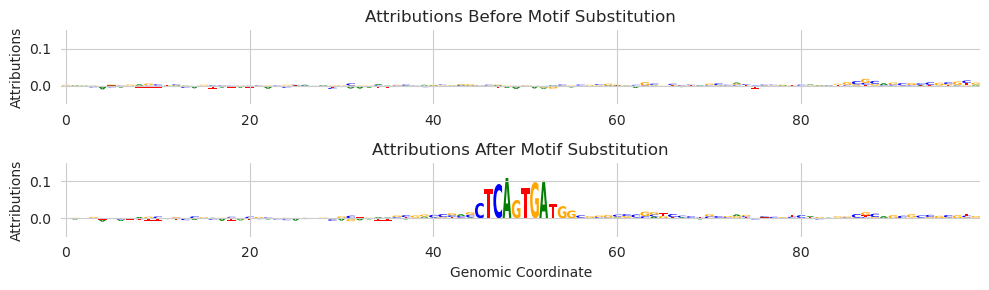

In [13]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(10, 3))
ax = plt.subplot(211)
plot_logo(attr_before[:, :, 950:1050].mean(dim=0), ax=ax)
plt.title("Attributions Before Motif Substitution")
plt.ylabel("Attributions")
plt.ylim(-0.05, 0.15)

ax = plt.subplot(212)
plot_logo(attr_after[:, :, 950:1050].mean(dim=0), ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("Attributions After Motif Substitution")
plt.ylim(-0.05, 0.15)

plt.tight_layout()
plt.show()

As you might expect, the attribution values highlight the included motif. We see multiple characters at some of the other positions because, although the `deep_lift_shap` function only provides attributions for the observed characters by default, we are averaging the attributions over many shuffled background sequences.

You may have noticed that we are only using a small number of background sequences here. That is because `deep_lift_shap` is run on each example before and after the substitution. Each time `deep_lift_shap` is run it constructs a set of (by default 20) references. For 5 background sequences, we are running 200 forward/backward passes through the model. This can scale up quite rapidly.

Finally, you might be wondering what the attribution was calculated with respect to. The `deep_lift_shap` function requires a single output target and Beluga has several thousand. By default, the attributions are calculated with respect to the first output. Coincidentally, for Beluga, this output is a DNase track and AP-1 motifs drive accessibility across many cell types. If you want to change the target -- or alter any of the other parameters -- you can pass in arguments as keywords.

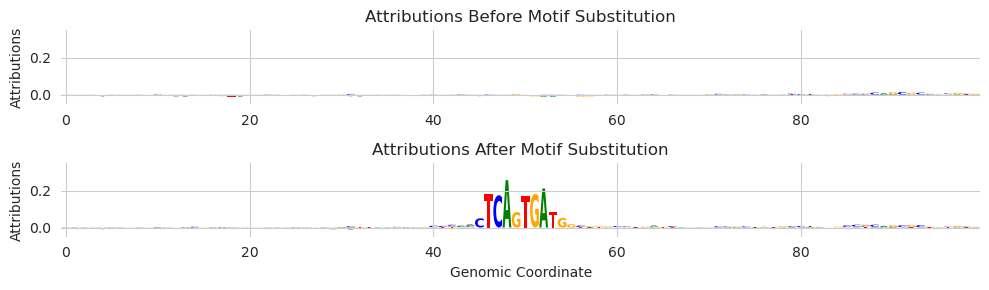

In [14]:
attr_before, attr_after = marginalize(model, X, "CTCAGTGATG", func=deep_lift_shap, target=267, device='cpu')

plt.figure(figsize=(10, 3))
ax = plt.subplot(211)
plot_logo(attr_before[:, :, 950:1050].mean(dim=0), ax=ax)
plt.title("Attributions Before Motif Substitution")
plt.ylabel("Attributions")
plt.ylim(-0.05, 0.35)

ax = plt.subplot(212)
plot_logo(attr_after[:, :, 950:1050].mean(dim=0), ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("Attributions After Motif Substitution")
plt.ylim(-0.05, 0.35)

plt.tight_layout()
plt.show()

Here, we passed in an additional parameter `target` and set that parameter to 267, which corresponds to a JunD ChIP-seq experiment.

All additional keyword arguments passed into `marginalize` are passed into the provided function. However, if this seems weird to you or you want to be certain that an argument is being passed into the function rather than being used by `marginalize` you can pass in a dictionary `additional_func_kwargs` where the keys are the names of the parameters and the values are the value that parameter should take.

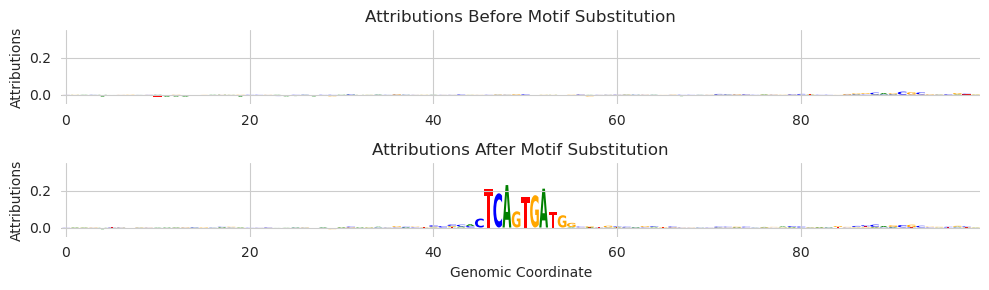

In [15]:
attr_before, attr_after = marginalize(model, X, "CTCAGTGATG", func=deep_lift_shap, additional_func_kwargs={'target': 267}, device='cpu')

plt.figure(figsize=(10, 3))
ax = plt.subplot(211)
plot_logo(attr_before[:, :, 950:1050].mean(dim=0), ax=ax)
plt.title("Attributions Before Motif Substitution")
plt.ylabel("Attributions")
plt.ylim(-0.05, 0.35)

ax = plt.subplot(212)
plot_logo(attr_after[:, :, 950:1050].mean(dim=0), ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("Attributions After Motif Substitution")
plt.ylim(-0.05, 0.35)

plt.tight_layout()
plt.show()

We can use this functionality to implement an alternate way of consider attributions when looking at marginalizations. Our basic intuition is that the background sequences that we add motifs to are sort of like the references that are constructed for methods like `deep_lift_shap`, so maybe we can just use them explicitly that way. Implementation-wise, this means setting the number of shuffles per example to 1 and increasing the number of background sequences.

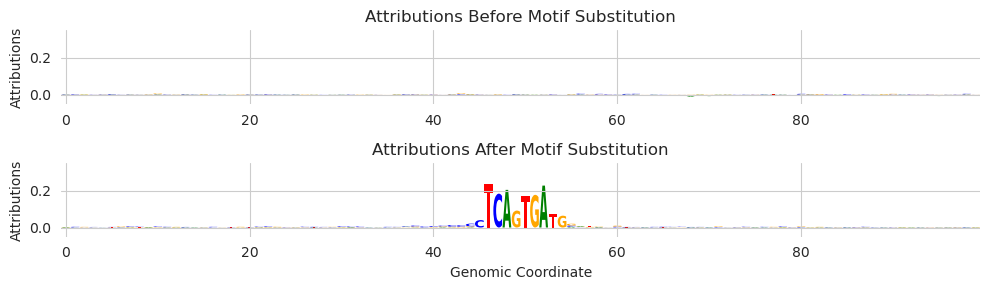

In [16]:
X = random_one_hot((100, 4, 2000)).type(torch.float32)
attr_before, attr_after = marginalize(model, X, "CTCAGTGATG", func=deep_lift_shap, target=267, n_shuffles=1, device='cpu')

plt.figure(figsize=(10, 3))
ax = plt.subplot(211)
plot_logo(attr_before[:, :, 950:1050].mean(dim=0), ax=ax)
plt.title("Attributions Before Motif Substitution")
plt.ylabel("Attributions")
plt.ylim(-0.05, 0.35)

ax = plt.subplot(212)
plot_logo(attr_after[:, :, 950:1050].mean(dim=0), ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("Attributions After Motif Substitution")
plt.ylim(-0.05, 0.35)

plt.tight_layout()
plt.show()

The attributions here do seem to be a bit cleaner than the attributions in the previous plots. We are trading having more accurate attributions for *each* example for having more examples to average over. In the marginalization setting, this might be the preferable choice.

#### Saturation Mutagenesis

An alternate method for calculating attributions is in silico saturation mutagenesis. Because the `marginalize` implementation is agnostic to the specific function that it is applying, we can drop it (or any custom function!) in just like we passed in `deep_lift_shap`.

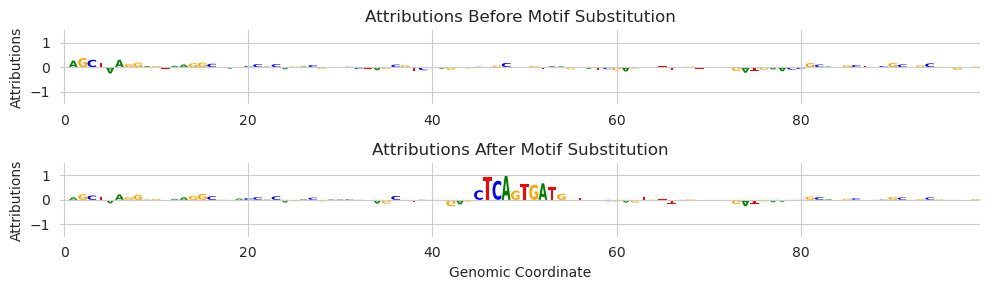

In [17]:
from tangermeme.ism import saturation_mutagenesis

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)
attr_before, attr_after = marginalize(model, X, "CTCAGTGATG", func=saturation_mutagenesis, target=267, device='cpu')

plt.figure(figsize=(10, 3))
ax = plt.subplot(211)
plot_logo(attr_before[0, :, 950:1050], ax=ax)
plt.title("Attributions Before Motif Substitution")
plt.ylabel("Attributions")
plt.ylim(-1.5, 1.5)

ax = plt.subplot(212)
plot_logo(attr_after[0, :, 950:1050], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("Attributions After Motif Substitution")
plt.ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

Like with the `deep_lift_shap` function, we can pass in additional arguments. In this case, we can pass in `start` and `end` in order to accelerate the calculation.

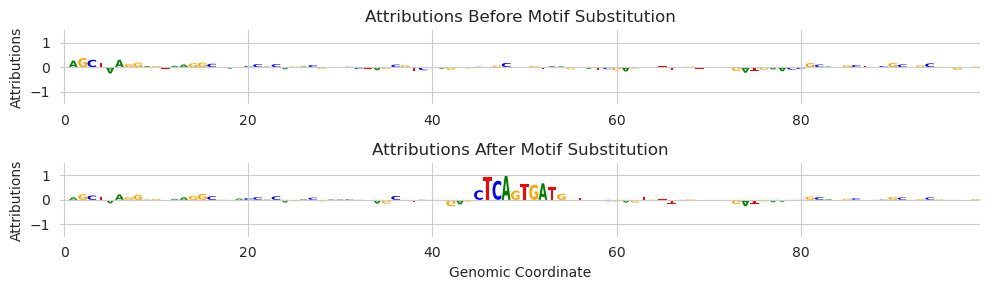

In [18]:
attr_before, attr_after = marginalize(model, X, "CTCAGTGATG", func=saturation_mutagenesis, device='cpu', 
    additional_func_kwargs={'target': 267, 'start': 950, 'end':1050})

plt.figure(figsize=(10, 3))
ax = plt.subplot(211)
plot_logo(attr_before[0], ax=ax)
plt.title("Attributions Before Motif Substitution")
plt.ylabel("Attributions")
plt.ylim(-1.5, 1.5)

ax = plt.subplot(212)
plot_logo(attr_after[0], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attributions")
plt.title("Attributions After Motif Substitution")
plt.ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()